In [ ]:
!pip install sentence-transformers google-search-results newspaper3k -Uqq

In [ ]:
import torch
from transformers import BertTokenizerFast, EncoderDecoderModel

from serpapi import GoogleSearch

from sentence_transformers import SentenceTransformer, util
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests

from newspaper import Article

# Get article from news site

In [ ]:
def get_article(link):
  article = Article(link, language='es')
  article.download()
  article.parse()

  return article.text

# Summarize

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
ckpt = 'mrm8488/bert2bert_shared-spanish-finetuned-summarization'
tokenizer = BertTokenizerFast.from_pretrained(ckpt)
model1 = EncoderDecoderModel.from_pretrained(ckpt).to(device)

def generate_summary(text):

   inputs = tokenizer([text], padding="max_length", truncation=True, max_length=512, return_tensors="pt")
   input_ids = inputs.input_ids.to(device)
   attention_mask = inputs.attention_mask.to(device)
   output = model1.generate(input_ids, attention_mask=attention_mask)
   return tokenizer.decode(output[0], skip_special_tokens=True)

# Goggle search

In [ ]:
def ggl_search(text):
  params = {
    "q": text,
    "tbm": "nws",
    "location": "Dallas",
    "api_key": "" #add api key here from https://serpapi.com/ 
  }

  search = GoogleSearch(params)
  results = search.get_dict()

  return results["news_results"]

# Similarity

In [ ]:
model = SentenceTransformer('hackathon-pln-es/paraphrase-spanish-distilroberta')

In [ ]:
def calc_similarity(sentence1, sentence2):


  # encode sentences to get their embeddings
  embedding1 = model.encode(sentence1, convert_to_tensor=True)
  embedding2 = model.encode(sentence2, convert_to_tensor=True)

  # compute similarity scores of two embeddings
  cosine_scores = util.pytorch_cos_sim(embedding1, embedding2)

  return cosine_scores

# Test on Mexico_train dataset



In [ ]:
df = pd.read_excel('/content/mexico_train.xlsx')
df

,Id,Category,Topic,Source,Headline,Text,Link
0,1,Fake,Education,El Ruinaversal,"RAE INCLUIRÁ LA PALABRA ""LADY"" EN EL DICCIONAR...","RAE INCLUIRÁ LA PALABRA ""LADY"" EN EL DICCIONAR...",http://www.elruinaversal.com/2017/06/10/rae-in...
1,2,Fake,Education,Hay noticia,"La palabra ""haiga"", aceptada por la RAE","La palabra ""haiga"", aceptada por la RAE La Rea...",https://haynoticia.es/la-palabra-haiga-aceptad...
2,3,Fake,Education,El Ruinaversal,YORDI ROSADO ESCRIBIRÁ Y DISEÑARÁ LOS NUEVOS L...,YORDI ROSADO ESCRIBIRÁ Y DISEÑARÁ LOS NUEVOS L...,http://www.elruinaversal.com/2018/05/06/yordi-...
3,4,True,Education,EL UNIVERSAL,UNAM capacitará a maestros para aprobar prueba...,UNAM capacitará a maestros para aprobar prueba...,http://www.eluniversal.com.mx/articulo/nacion/...
4,5,Fake,Education,Lamula,pretenden aprobar libros escolares con conteni...,Alerta: pretenden aprobar libros escolares con...,https://redaccion.lamula.pe/2018/06/19/memoria...
...,...,...,...,...,...,...,...
671,672,Fake,Entertainment,El Dizque,Madonna será la nueva imagen del Chocolate Abu...,Madonna será la nueva imagen del Chocolate Abu...,https://www.eldizque.com/madonna-sera-la-nueva...
672,673,True,Entertainment,Radio Formula,"Filtran material íntimo de Zelina Vega, luchad...","Filtran material íntimo de Zelina Vega, luchad...",http://www.radioformula.com.mx/notas.asp?Idn=7...
673,674,Fake,Entertainment,La Voz Popular,CBS PLANEA GRAN HERMANO EN LA CASA BLANCA CON ...,CBS PLANEA GRAN HERMANO EN LA CASA BLANCA CON ...,http://lavozpopular.com/cbs-planea-gran-herman...
674,675,Fake,Entertainment,El Dizque,TV Azteca anuncia que cambiará su nombre por u...,TV Azteca anuncia que cambiará su nombre por u...,https://www.eldizque.com/tv-azteca-anuncia-que...


In [ ]:
fake_links = []
true_links = []
true_articles = []
fake_articles = []

for i in range(100):
  if  df.iloc[i]['Category'] == 'True':
    try:
      article = get_article(df.iloc[i]['Link'])
      if len(article) != 0:
        true_links.append(df.iloc[i]['Link'])
        true_articles.append(article)
    except:
      pass
    
  elif  df.iloc[i]['Category'] == 'Fake':
    try:
      article = get_article(df.iloc[i]['Link'])
      if len(article) != 0:
        fake_links.append(df.iloc[i]['Link'])
        fake_articles.append(article)
    except:
      pass

In [ ]:
true_articles = true_articles[0:20]
fake_articles = fake_articles[0:20]

In [ ]:
# Summarize true articles

true_summ = []
for article in true_articles:
  true_summ.append(generate_summary(article))


/usr/local/lib/python3.7/dist-packages/transformers/generation_utils.py:1301: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 64 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  UserWarning,


In [ ]:
# Search google for the true articles

true_search_links = []

for i in range(20):
  try:
    news_results = ggl_search(true_summ[i])
    true_search_links.append([i, [news_result['link'] for news_result in news_results if news_result['link'] != true_links[i]]])
  except:
    pass

In [ ]:
# calculate similarity  score

sim_score = {}
for i in range(len(true_search_links)):
  sim_score[true_search_links[i][0]] = []

for i in range(len(true_search_links)):
  for link in true_search_links[i][1]:
    try:
      article = get_article(link)
      if len(article) != 0:
        score = calc_similarity(true_summ[true_search_links[i][0]], generate_summary(article))
        sim_score[true_search_links[i][0]].append(score)
        
    except:
      pass
      
true_score = []
for s in sim_score:
  try:
  
    true_score.append(sum(sim_score[s]).cpu().numpy())
  except:
     true_score.append(sum(sim_score[s]))
true_score

/usr/local/lib/python3.7/dist-packages/numpy/ma/core.py:2830: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  order=order, subok=True, ndmin=ndmin)


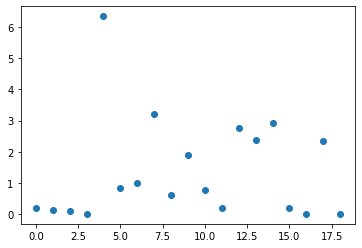

In [ ]:
plt.scatter([range(len(true_score))], true_score)
plt.show()

In [ ]:
# Summarize fake articles

fake_summ = []
for article in fake_articles:
  fake_summ.append(generate_summary(article))

In [ ]:
# Search google for the fake articles

fake_search_links = []
for i in range(20):
  try:
    news_results = ggl_search(fake_summ[i])
    fake_search_links.append([i,[news_result['link'] for news_result in news_results if news_result['link'] != fake_links[i]]])
  except:
    pass

In [ ]:
fake_sim_score = {}
for i in range(len(fake_search_links)):
  fake_sim_score[fake_search_links[i][0]] = []


In [ ]:
for i in range(len(fake_search_links)):
  for link in fake_search_links[i][1]:
    try:
      article = get_article(link)
      if len(article) != 0:
        fake_score = calc_similarity(fake_summ[fake_search_links[i][0]], generate_summary(article))
        fake_sim_score[fake_search_links[i][0]].append(score)
        
    except:
      pass

In [ ]:
fake_score = []
for s in fake_sim_score:
  try:
  
    fake_score.append(sum(fake_sim_score[s]).cpu().numpy())
  except:
     fake_score.append(sum(fake_sim_score[s]))
fake_score

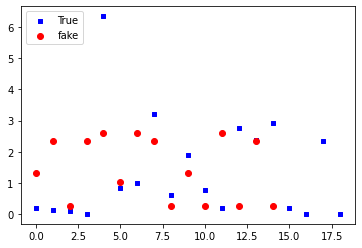

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter([range(len(true_score))], true_score, s=10, c='b', marker="s", label='True')
ax1.scatter([range(len(fake_score))], fake_score, marker="o",c='r', label='fake')
plt.legend(loc='upper left');
plt.show()